# Movie Topic Clustering Based On NLP (Python)

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
# REGULAR EXPRESSION
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/souyixin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/souyixin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read data from files. In summary, we have 100 titles and 100 synopsis (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [3]:
import nltk
nltk.download('stopwords')
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/souyixin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
We use 179 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    # exclude stop words and tokenize the document, generate a list of string 
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# tokenization without stemming
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
# tokenization and stemming
tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
# 1. do tokenization and stemming for all the documents
# 2. also just do tokenization for all the documents
# the goal is to create a mapping from stemmed words to original tokenized words for result interpretation.
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [7]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print (vocab_frame_dict['angel'])

angeles


# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

***example:***

document1: "Arthur da Jason"

document 2: "Jason da da huang"

document1: tf-idf [2, 0.5, 0.5, 0];  document2: tf-idf [0, 1, 0.5, 1]  

2-gram: 

document 1: Arthur da, da Jason; document 2: Jason da, da da, da huang bigram

3-gram:

document 1: Athur da Jason;  document 2: Jason da da, da da huang

In [8]:
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: total maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=2000,
                                 min_df=0, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,3))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 2000 terms.


In [9]:
# check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 2000,
 'min_df': 0,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [10]:
# words
tf_selected_words = tfidf_model.get_feature_names()

In [11]:
# print out words
tf_selected_words

["'d",
 "'m",
 "'s apart",
 "'s arm",
 "'s bodi",
 "'s death",
 "'s father",
 "'s friend",
 "'s home",
 "'s hous",
 "'s life",
 "'s marriag",
 "'s men",
 "'s mother",
 "'s murder",
 "'s offic",
 "'s plan",
 "'s son",
 "'s voic",
 "'s wife",
 'abandon',
 'abil',
 'abl',
 'aboard',
 'abus',
 'accept',
 'accid',
 'accident',
 'accompani',
 'accomplic',
 'accus',
 'acquaint',
 'act',
 'action',
 'actor',
 'actual',
 'adam',
 'address',
 'admir',
 'admit',
 'adrian',
 'advanc',
 'advantag',
 'adventur',
 'advis',
 'affair',
 'africa',
 'african',
 'african queen',
 'afterward',
 'age',
 'agent',
 'ago',
 'agre',
 'ahead',
 'aid',
 'aim',
 'air',
 'aircraft',
 'airport',
 'al',
 'albert',
 'alcohol',
 'alderaan',
 'alex',
 'alexand',
 'ali',
 'alic',
 'alien',
 'aliv',
 'allenbi',
 'allnut',
 'allow',
 'alon',
 'alreadi',
 'altern',
 'alvi',
 'alway',
 'ambush',
 'america',
 'american',
 'ami',
 'andi',
 "andi 's",
 'andrew',
 'angel',
 'angela',
 'anger',
 'angri',
 'angrili',
 'anim',
 'an

In [12]:
# tf-idf matrix
tfidf_matrix

<100x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 31769 stored elements in Compressed Sparse Row format>

# Calculate Document Similarity

In [13]:
# use cosine similarity to check the similarity for two documents
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print (cos_matrix)

[[1.         0.01587253 0.01952566 ... 0.02251429 0.02280225 0.04400671]
 [0.01587253 1.         0.0314611  ... 0.01242858 0.01335847 0.01926311]
 [0.01952566 0.0314611  1.         ... 0.01612858 0.01253687 0.04145735]
 ...
 [0.02251429 0.01242858 0.01612858 ... 1.         0.03184383 0.0459994 ]
 [0.02280225 0.01335847 0.01253687 ... 0.03184383 1.         0.01976441]
 [0.04400671 0.01926311 0.04145735 ... 0.0459994  0.01976441 1.        ]]


# Part 4: K-means clustering

In [14]:
# k-means clustering
from sklearn.cluster import KMeans

# number of clusters
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [15]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'index': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['index', 'title', 'cluster'])

In [16]:
frame.head(10)

,index,title,cluster
2,0,The Godfather,2
3,1,The Shawshank Redemption,3
0,2,Schindler's List,0
4,3,Raging Bull,4
0,4,Casablanca,0
3,5,One Flew Over the Cuckoo's Nest,3
1,6,Gone with the Wind,1
3,7,Citizen Kane,3
2,8,The Wizard of Oz,2
3,9,Titanic,3


In [17]:
print ("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
1,35
3,26
4,14
0,14
2,11


In [19]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ",", end='')
    print ()
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print (", ".join(cluster_movies))
    print ()

<Document clustering result by K-means>
Cluster 0 words:alex,travis,schindler,rick,emma,spade,
Cluster 0 titles (14 movies): 
Schindler's List, Casablanca, Psycho, Vertigo, West Side Story, The Silence of the Lambs, Goodfellas, The French Connection, Terms of Endearment, American Graffiti, The Maltese Falcon, A Clockwork Orange, Taxi Driver, The Third Man

Cluster 1 words:paul,soldiers,wallaces,forrestal,juror,beale,
Cluster 1 titles (35 movies): 
Gone with the Wind, Lawrence of Arabia, Forrest Gump, Star Wars, The Bridge on the River Kwai, 12 Angry Men, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, Gandhi, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, The Philadelphia Story, To Kill a Mockingbird, The Best Years of Our Lives, Ben-Hur, Patton, Braveheart, The Good, the Bad and the Ugly, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Pianist, All Quiet on the W

## 4.2. Plot K-means Result

In [20]:
# use pca to reduce dimensions to 2d for visibility, just want to see if there 2d can give us some insights
# this is not an appropriate method, just a guess.
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

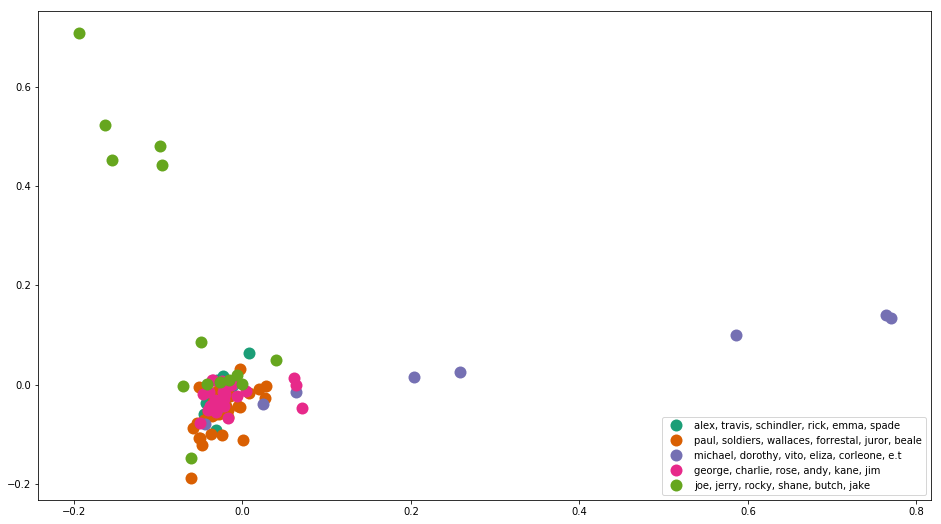

In [21]:
# %matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [22]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [23]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, learning_method = 'online')

In [24]:
# LDA requires integer values, keep first 3 digits
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [25]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [26]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)

(5, 2000)


In [27]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [28]:
# documents and topics matri
doc_topic = lda.transform(tfidf_matrix_lda)
print (doc_topic.shape)

(100, 5)


In [29]:
# print out the clusters and topics and titles of the movies
topic_doc_dict = {}
print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print (', '.join(topic_doc_dict[i]))
    print ()

<Document clustering result by LDA>
Cluster 1 words: paul, michael, travis, forrestal, terry, emma
Cluster 1 titles (22 movies): 
The Godfather, The Godfather: Part II, Sunset Blvd., On the Waterfront, Forrest Gump, The Sound of Music, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Amadeus, Saving Private Ryan, An American in Paris, The Best Years of Our Lives, My Fair Lady, The Good, the Bad and the Ugly, All Quiet on the Western Front, City Lights, Terms of Endearment, The Grapes of Wrath, Shane, The Green Mile, Taxi Driver, The Third Man, Yankee Doodle Dandy

Cluster 2 words: dorothy, beale, george, andy, munny, maximus
Cluster 2 titles (20 movies): 
The Shawshank Redemption, Gone with the Wind, Citizen Kane, The Wizard of Oz, E.T. the Extra-Terrestrial, The Silence of the Lambs, Chinatown, It's a Wonderful Life, Apocalypse Now, Gladiator, Unforgiven, Raiders of the Lost Ark, The Philadelphia Story, Patton, It Happened One Night, Tootsie, Network, The Graduate